# Data

In [1]:
import os
import sys
root_dir = os.path.abspath(os.path.join(os.path.dirname('../full_portfolio_analysis.ipynb'), '..'))
os.chdir(root_dir)
sys.path.insert(0, os.path.join(root_dir, 'src'))

In [2]:
from backtest.utils import run_strategy, run_wfo


from backtesting import Backtest
import pandas as pd
import pandas_ta as pandas_ta
import MetaTrader5 as mt5
import MetaTrader5 as mt5
import pandas as pd
from backtest.get_data import get_data
import pytz
from datetime import datetime
from pandas import Timestamp
import numpy as np
import random

random.seed(42)

In [3]:
initial_cash = 10_000
margin = 1/30
commission = 7e-4

In [ ]:
# establish connection to the MetaTrader 5 terminal
if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    quit()
 
# get all symbols
symbols = mt5.symbols_get()

groups = []
for symbol in symbols:
    group = symbol.path.split('\\')[0]
    if not group in groups:
        groups.append(group)
groups


['Forex_Indicator',
 'CryptoCross_grp',
 'Crypto_group',
 'Energies_group',
 'Forex_group',
 'Indices_group',
 'Stocks_group']

In [5]:

tickers = [symbol.path.split('\\')[1] for symbol in symbols if 'Crypto_group' in symbol.path or 'CryptoCross_grp' in symbol.path and symbol.spread > 30]
# tickers = ['USOILm']

print(tickers)

# Establecer la zona horaria a UTC
timezone = pytz.timezone("Etc/UTC")

# Crear objetos 'datetime' en zona horaria UTC
date_from = datetime(2021, 10, 1, tzinfo=timezone)
date_to = datetime(2024, 9, 1, tzinfo=timezone)

intervals = [
    mt5.TIMEFRAME_H4,
    mt5.TIMEFRAME_H2,
    mt5.TIMEFRAME_H1,
    mt5.TIMEFRAME_M15,
]

symbols = get_data(tickers, intervals, date_from, date_to)

['BTCAUDm', 'BTCCNHm', 'BTCTHBm', 'BTCXAGm', 'BTCXAUm', 'BTCZARm', 'BCHUSDm', 'BTCJPYm', 'BTCKRWm', 'BTCUSDm', 'ETHUSDm', 'LTCUSDm', 'XRPUSDm', 'ADAUSDm', 'BATUSDm', 'BNBUSDm', 'DOTUSDm', 'ENJUSDm', 'FILUSDm', 'SNXUSDm', 'SOLUSDm', 'UNIUSDm', 'XTZUSDm', '1INCHUSDm', 'AAVEUSDm', 'CAKEUSDm', 'COMPUSDm', 'DOGEUSDm', 'HBARUSDm', 'HTUSDm', 'IOSTUSDm', 'LINKUSDm', 'MANAUSDm', 'MATICUSDm', 'THETAUSDm']
MetaTrader5 package author:  MetaQuotes Ltd.
MetaTrader5 package version:  5.0.4288
BTCAUDm
BTCAUDm
BTCAUDm
BTCAUDm
BTCCNHm
BTCCNHm
BTCCNHm
BTCCNHm
BTCTHBm
BTCTHBm
BTCTHBm
BTCTHBm
BTCXAGm
BTCXAGm
BTCXAGm
BTCXAGm
BTCXAUm
BTCXAUm
BTCXAUm
BTCXAUm
BTCZARm
BTCZARm
BTCZARm
BTCZARm
BCHUSDm
BCHUSDm
BCHUSDm
BCHUSDm
BTCJPYm
BTCJPYm
BTCJPYm
BTCJPYm
BTCKRWm
se descarto BTCKRWm
BTCKRWm
se descarto BTCKRWm
BTCKRWm
se descarto BTCKRWm
BTCKRWm
se descarto BTCKRWm
BTCUSDm
BTCUSDm
BTCUSDm
BTCUSDm
ETHUSDm
ETHUSDm
ETHUSDm
ETHUSDm
LTCUSDm
LTCUSDm
LTCUSDm
LTCUSDm
XRPUSDm
XRPUSDm
XRPUSDm
XRPUSDm
ADAUSDm
se descarto A

In [6]:
max_start_date = None
intervals_start_dates = {}

tickers = np.unique(list(symbols.keys())).tolist()

for interval in intervals:
    for ticker in tickers:
        if not max_start_date or symbols[ticker][interval].index.min() > max_start_date:
            max_start_date = symbols[ticker][interval].index.min()
        
    intervals_start_dates[interval] = max_start_date

intervals_start_dates

{16388: Timestamp('2021-10-27 16:00:00+0000', tz='UTC'),
 16386: Timestamp('2021-10-27 16:00:00+0000', tz='UTC'),
 16385: Timestamp('2021-10-27 17:00:00+0000', tz='UTC'),
 15: Timestamp('2021-10-27 17:15:00+0000', tz='UTC')}

In [7]:
start_date_train = Timestamp('2023-09-01 00:00:00', tz='UTC')
limit_date_train = Timestamp('2024-09-01 00:00:00', tz='UTC')

print(start_date_train)
print(limit_date_train)

2023-09-01 00:00:00+00:00
2024-09-01 00:00:00+00:00


# Analisis preliminar

In [8]:
from backtesting import Strategy
import talib as ta
from backbone.utils.general_purpose import calculate_units_size, diff_pips

class MeanReversion(Strategy):
    pip_value = None
    minimum_lot = None
    contract_volume = None
    minimum_units = None
    
    sma_period = 50
    deviation_threshold = 0.01
    risk = 1
    cum_rsi_up_threshold = 90
    cum_rsi_down_threshold = 10
    atr_multiplier = 2
    
    def init(self):
        self.sma = self.I(ta.SMA, self.data.Close, timeperiod=self.sma_period)
        self.rsi = self.I(ta.RSI, self.data.Close, timeperiod=2)
        self.atr = self.I(ta.ATR, self.data.High, self.data.Low, self.data.Close)
        
        self.minimum_units = self.minimum_lot * self.contract_volume


    def next(self):
        # Precio actual y valor de la SMA
        actual_close = self.data.Close[-1]
        sma_value = self.sma[-1]
        cum_rsi = self.rsi[-1] + self.rsi[-2]

        # Desviación del precio con respecto a la SMA (en porcentaje)
        deviation = (actual_close - sma_value) / sma_value

        if self.position:
            if self.position.is_long and actual_close >= self.sma:
                self.position.close()

            if self.position.is_short and actual_close <= self.sma:
                self.position.close()  
        
        else:
            # Condiciones para comprar (precio por debajo de la SMA más del umbral de desviación)
            if deviation <= -self.deviation_threshold and cum_rsi <= self.cum_rsi_down_threshold:
                sl_price = self.data.Close[-1] - self.atr_multiplier * self.atr[-1]
                
                pip_distance = diff_pips(
                    self.data.Close[-1], 
                    sl_price, 
                    pip_value=self.pip_value
                )
                
                units = calculate_units_size(
                    account_size=self.equity, 
                    risk_percentage=self.risk, 
                    stop_loss_pips=pip_distance, 
                    pip_value=self.pip_value
                )
                
                if units < self.minimum_units:
                    units = self.minimum_units
                
                self.buy(
                    size=units,
                    sl=sl_price
                )

            # Condiciones para vender (precio por encima de la SMA más del umbral de desviación)
            elif deviation >= self.deviation_threshold and cum_rsi >= self.cum_rsi_up_threshold:
                sl_price = self.data.Close[-1] + self.atr_multiplier * self.atr[-1]
                
                pip_distance = diff_pips(
                    self.data.Close[-1], 
                    sl_price, 
                    pip_value=self.pip_value
                )
                
                units = calculate_units_size(
                    account_size=self.equity, 
                    risk_percentage=self.risk, 
                    stop_loss_pips=pip_distance, 
                    pip_value=self.pip_value
                )
                
                if units < self.minimum_units:
                    units = self.minimum_units
                
                self.sell(
                    size=units,
                    sl=sl_price
                )

In [9]:
import itertools
import numpy as np
from sklearn.linear_model import LinearRegression

strategies = [
    MeanReversion
]

experiments = list(itertools.product(
    tickers, intervals, strategies
))

performance = pd.DataFrame()

for ticker, interval, strategy in experiments:
    try:
        print(ticker, interval)

        df_stats = run_strategy(
            strategy=strategy,
            ticker=ticker,
            interval=interval,
            commission=commission, 
            prices=symbols[ticker][interval], 
            initial_cash=initial_cash, 
            margin=1/30
        )

        performance = pd.concat([performance, df_stats])

    except:
        print(f'hubo un problema con {ticker} {interval}')


performance['return/dd'] = performance['return'] / -performance['drawdown']
performance['drawdown'] = -performance['drawdown']
performance['custom_metric'] = (performance['return'] / (1 + performance.drawdown)) * np.log(1 + performance.trades)


AAVEUSDm 16388
AAVEUSDm 16386
AAVEUSDm 16385
hubo un problema con AAVEUSDm 16385
AAVEUSDm 15
hubo un problema con AAVEUSDm 15
BATUSDm 16388
BATUSDm 16386
BATUSDm 16385
BATUSDm 15
BCHUSDm 16388
BCHUSDm 16386
BCHUSDm 16385
BCHUSDm 15
BTCAUDm 16388
BTCAUDm 16386


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backtest\utils.py:351: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_train = Backtest(
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backtest\utils.py:351: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_train = Backtest(


BTCAUDm 16385


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backtest\utils.py:351: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_train = Backtest(


BTCAUDm 15


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backtest\utils.py:351: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_train = Backtest(


BTCCNHm 16388
BTCCNHm 16386


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backtest\utils.py:351: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_train = Backtest(
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backtest\utils.py:351: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_train = Backtest(


BTCCNHm 16385


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backtest\utils.py:351: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_train = Backtest(


BTCCNHm 15


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backtest\utils.py:351: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_train = Backtest(


BTCJPYm 16388
BTCJPYm 16386


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backtest\utils.py:351: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_train = Backtest(
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backtest\utils.py:351: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_train = Backtest(


BTCJPYm 16385


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backtest\utils.py:351: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_train = Backtest(


BTCJPYm 15


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backtest\utils.py:351: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_train = Backtest(


BTCTHBm 16388
BTCTHBm 16386


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backtest\utils.py:351: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_train = Backtest(
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backtest\utils.py:351: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_train = Backtest(


BTCTHBm 16385


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backtest\utils.py:351: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_train = Backtest(


BTCTHBm 15


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backtest\utils.py:351: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_train = Backtest(


BTCUSDm 16388
BTCUSDm 16386
BTCUSDm 16385
BTCUSDm 15
BTCXAGm 16388
BTCXAGm 16386
BTCXAGm 16385
BTCXAGm 15
BTCXAUm 16388
BTCXAUm 16386
BTCXAUm 16385
BTCXAUm 15
BTCZARm 16388
BTCZARm 16386


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backtest\utils.py:351: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_train = Backtest(
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backtest\utils.py:351: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_train = Backtest(


BTCZARm 16385


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backtest\utils.py:351: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_train = Backtest(


BTCZARm 15


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backtest\utils.py:351: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_train = Backtest(


ETHUSDm 16388
ETHUSDm 16386
ETHUSDm 16385
ETHUSDm 15
LINKUSDm 16388
LINKUSDm 16386
LINKUSDm 16385
LINKUSDm 15
LTCUSDm 16388
LTCUSDm 16386
LTCUSDm 16385
LTCUSDm 15
SNXUSDm 16388
SNXUSDm 16386
SNXUSDm 16385
SNXUSDm 15
UNIUSDm 16388
UNIUSDm 16386
UNIUSDm 16385
UNIUSDm 15
XRPUSDm 16388
XRPUSDm 16386
XRPUSDm 16385
XRPUSDm 15


In [14]:

filter_performance = performance[
    (performance['return/dd']>1)
    & (performance['stability_ratio']>0.7)
].sort_values(by=['return/dd'], ascending=[False])#.drop_duplicates(subset=['ticker'], keep='first')

portfolio = filter_performance.ticker.tolist()
intervals = filter_performance.interval.values.tolist()

display(filter_performance)

# portfolio

,strategy,ticker,interval,stability_ratio,return,final_eq,drawdown,drawdown_duration,win_rate,sharpe_ratio,trades,avg_trade_percent,exposure,final_equity,Duration,return/dd,custom_metric
0,MeanReversion,XRPUSDm,16388,0.781681,27.947195,12794.719503,13.829932,405 days 12:00:00,50.566038,0.606924,265,0.262214,71.334617,12794.719503,1039 days 08:00:00,2.020776,10.52217


In [15]:
for ticker, interval in zip(portfolio, intervals):
    df_stats = run_strategy(
        strategy=strategy,
        ticker=ticker,
        interval=interval,
        commission=commission, 
        prices=symbols[ticker][interval], 
        initial_cash=initial_cash, 
        margin=1/30,
        plot=True
    )


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


# WFO

In [16]:
from backtest.utils import optim_func_2

strategy = MeanReversion
lookback_bars = 1000
validation_bars = 100
warmup_bars = 50

all_wfo_performances = pd.DataFrame()
stats_per_symbol = {}

params = {
    'deviation_threshold': list(np.arange(0.01, 0.2, 0.01).round(2)),
    'sma_period': [50],
}

for index, row in filter_performance.iterrows():
    
    # try:
    ticker = row.ticker
    interval = row.interval
    
    print(ticker, interval)
    
    prices = symbols[ticker][interval]

    wfo_stats, df_stats = run_wfo(
        strategy=strategy,
        ticker=ticker,
        interval=interval,
        prices=prices,
        initial_cash=initial_cash,
        commission=commission,
        margin=margin,
        optim_func=optim_func_2,
        params=params,
        lookback_bars=lookback_bars,
        warmup_bars=warmup_bars,
        validation_bars=validation_bars
    )
    
    if ticker not in stats_per_symbol.keys():
        stats_per_symbol[ticker] = {}

    stats_per_symbol[ticker][interval] = wfo_stats

    all_wfo_performances = pd.concat([all_wfo_performances, df_stats])
    
    # except:
    #     print(f'No se pudo ejecutar para el ticker {ticker}')

all_wfo_performances['return/dd'] = all_wfo_performances['return'] / -all_wfo_performances['drawdown']
all_wfo_performances['drawdown'] = -all_wfo_performances['drawdown']
all_wfo_performances['custom_metric'] = (all_wfo_performances['return'] / (1 + all_wfo_performances.drawdown)) * np.log(1 + all_wfo_performances.trades)

all_wfo_performances.drawdown_duration = pd.to_timedelta(all_wfo_performances.drawdown_duration)
all_wfo_performances.drawdown_duration = all_wfo_performances.drawdown_duration.dt.days

all_wfo_performances.sort_values(by='return/dd', ascending=False)

XRPUSDm 16388


,strategy,ticker,interval,stability_ratio,return,final_eq,drawdown,drawdown_duration,win_rate,sharpe_ratio,trades,avg_trade_percent,exposure,final_equity,Duration,return/dd,custom_metric
0,MeanReversion,XRPUSDm,16388,0.774864,19.442126,11944.21258,8.295658,327,51.470588,0.816299,136,0.619925,1.588065,11944.21258,1039 days 08:00:00,2.343651,10.290276


# Montecarlo

In [17]:
filtered_wfo_performance = all_wfo_performances[
    (all_wfo_performances['stability_ratio'] > 0.7)
].sort_values(by='return/dd', ascending=False)

filtered_wfo_performance

,strategy,ticker,interval,stability_ratio,return,final_eq,drawdown,drawdown_duration,win_rate,sharpe_ratio,trades,avg_trade_percent,exposure,final_equity,Duration,return/dd,custom_metric
0,MeanReversion,XRPUSDm,16388,0.774864,19.442126,11944.21258,8.295658,327,51.470588,0.816299,136,0.619925,1.588065,11944.21258,1039 days 08:00:00,2.343651,10.290276


In [18]:
# stats_per_symbol['UKOILm'][16386]['_trades']

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from backtest.utils import montecarlo_statistics_simulation

# Crear una lista para almacenar los resultados de cada ticker
data_drawdown = []
data_return = []
montecarlo_simulations = {}

all_drawdowns = pd.DataFrame()
all_returns = pd.DataFrame()

for index, row in filtered_wfo_performance.iterrows():
    ticker = row.ticker
    interval = row.interval
    
    print(f"Procesando ticker: {ticker}")
    trades_history = stats_per_symbol[ticker][interval]._trades
    eq_curve = stats_per_symbol[ticker][interval]._equity_curve
    
    # Simulación de Montecarlo para cada ticker (datos agregados)
    mc, synthetic_drawdown_curve, synthetic_return_curve = montecarlo_statistics_simulation(
        equity_curve=eq_curve,
        trade_history=trades_history, 
        n_simulations=100_000, 
        initial_equity=initial_cash, 
        threshold_ruin=0.8, 
        return_raw_curves=True,
        percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]
    )
    
    montecarlo_simulations[ticker] = mc
    
    synthetic_drawdown_curve['ticker'] = ticker
    synthetic_return_curve['ticker'] = ticker
    
    all_drawdowns = pd.concat([all_drawdowns, synthetic_drawdown_curve])
    all_returns = pd.concat([all_returns, synthetic_return_curve])

Procesando ticker: XRPUSDm


In [21]:
dd_df = pd.DataFrame()
returns_df = pd.DataFrame()

for ticker, mc in montecarlo_simulations.items():
    mc = mc.rename(
        columns={
            'Drawdown (%)': f'drawdown_{ticker}',
            'Final Return (%)': f'return_{ticker}',
        }
    )

    if dd_df.empty:
        dd_df = mc[[f'drawdown_{ticker}']]
    
    else:
        dd_df = pd.merge(
            dd_df,
            mc[[f'drawdown_{ticker}']],
            left_index=True,
            right_index=True            
        )
        
    if returns_df.empty:
        returns_df = mc[[f'return_{ticker}']]
    
    else:
        returns_df = pd.merge(
            returns_df,
            mc[[f'return_{ticker}']],
            left_index=True,
            right_index=True            
        )
        
display(dd_df)
display(returns_df)


,drawdown_XRPUSDm
count,100000.000000
mean,-9.402504
std,3.654407
min,-37.298038
10%,-14.336351
25%,-11.261192
50%,-8.645006
75%,-6.772454
90%,-5.501449
max,-2.331778


,return_XRPUSDm
count,100000.000000
mean,21.873059
std,16.621548
min,-34.585501
10%,1.481144
25%,10.245422
50%,20.721449
75%,32.285548
90%,43.693570
max,117.718262


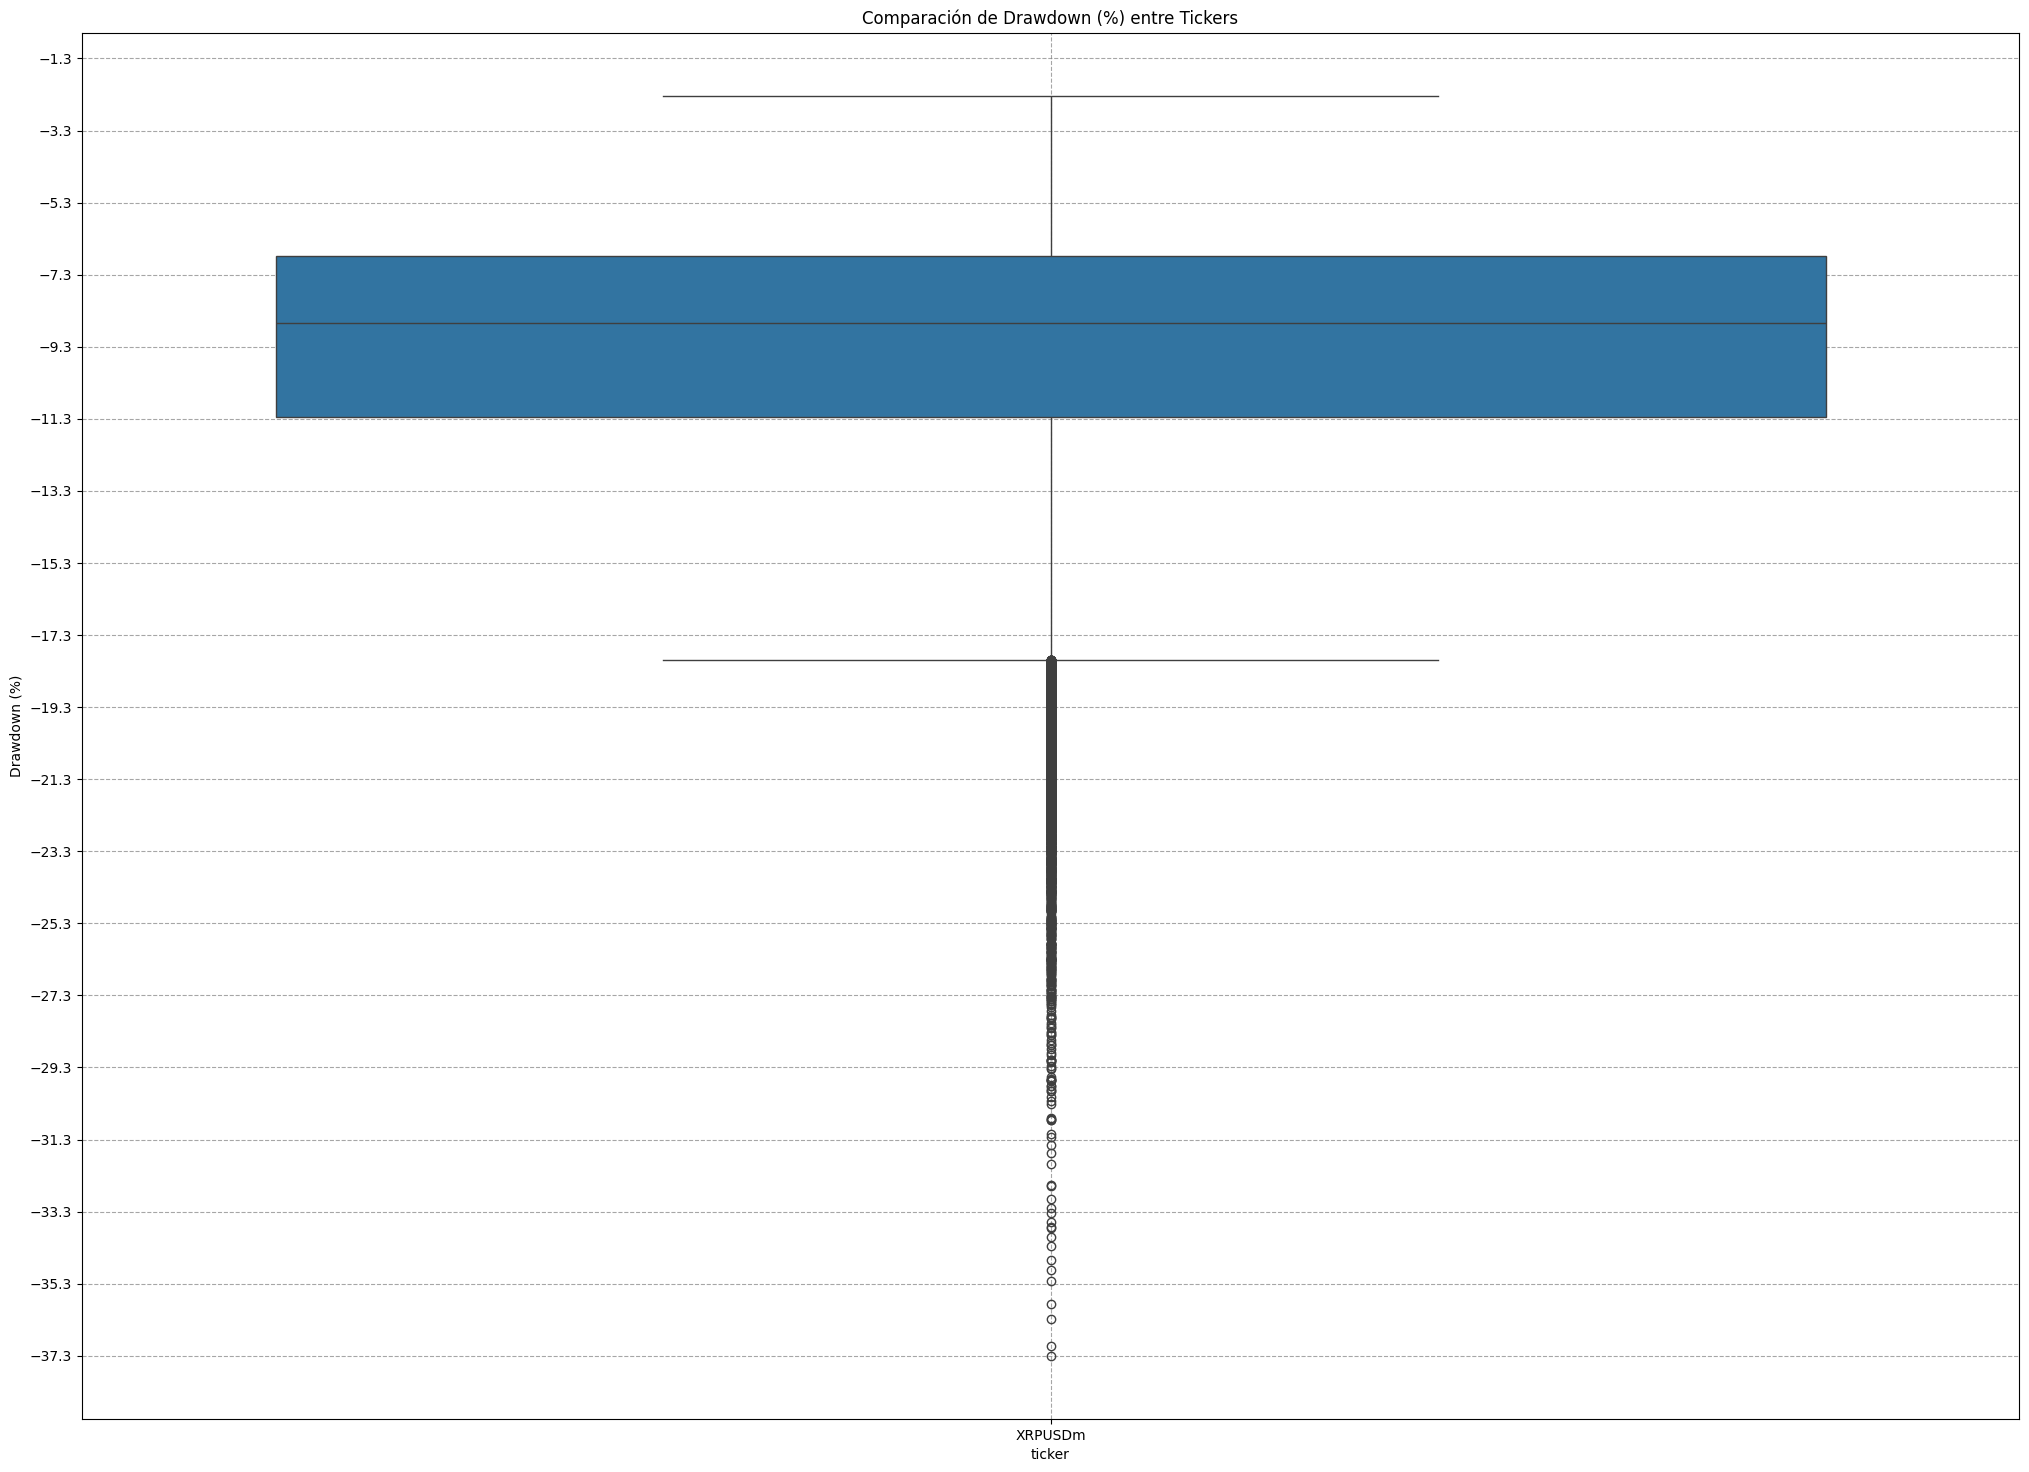

In [22]:
# Configurar el gráfico con matplotlib y seaborn
plt.figure(figsize=(25, 18))
sns.boxplot(data=all_drawdowns, x="ticker", y="Drawdown (%)")
plt.title("Comparación de Drawdown (%) entre Tickers")

y_max = all_drawdowns["Drawdown (%)"].max()  # Valor máximo en el eje Y
y_min = all_drawdowns["Drawdown (%)"].min()  # Valor mínimo en el eje Y
tick_interval = 2  # Intervalo deseado entre números en el eje Y

# Configurar los ticks mayores en el eje Y
plt.yticks(np.arange(y_min, y_max + tick_interval, tick_interval))

# Activar la cuadrícula
plt.grid(True, linestyle='--', which='both', color='grey', alpha=0.7)

# Mostrar el gráfico
plt.show()


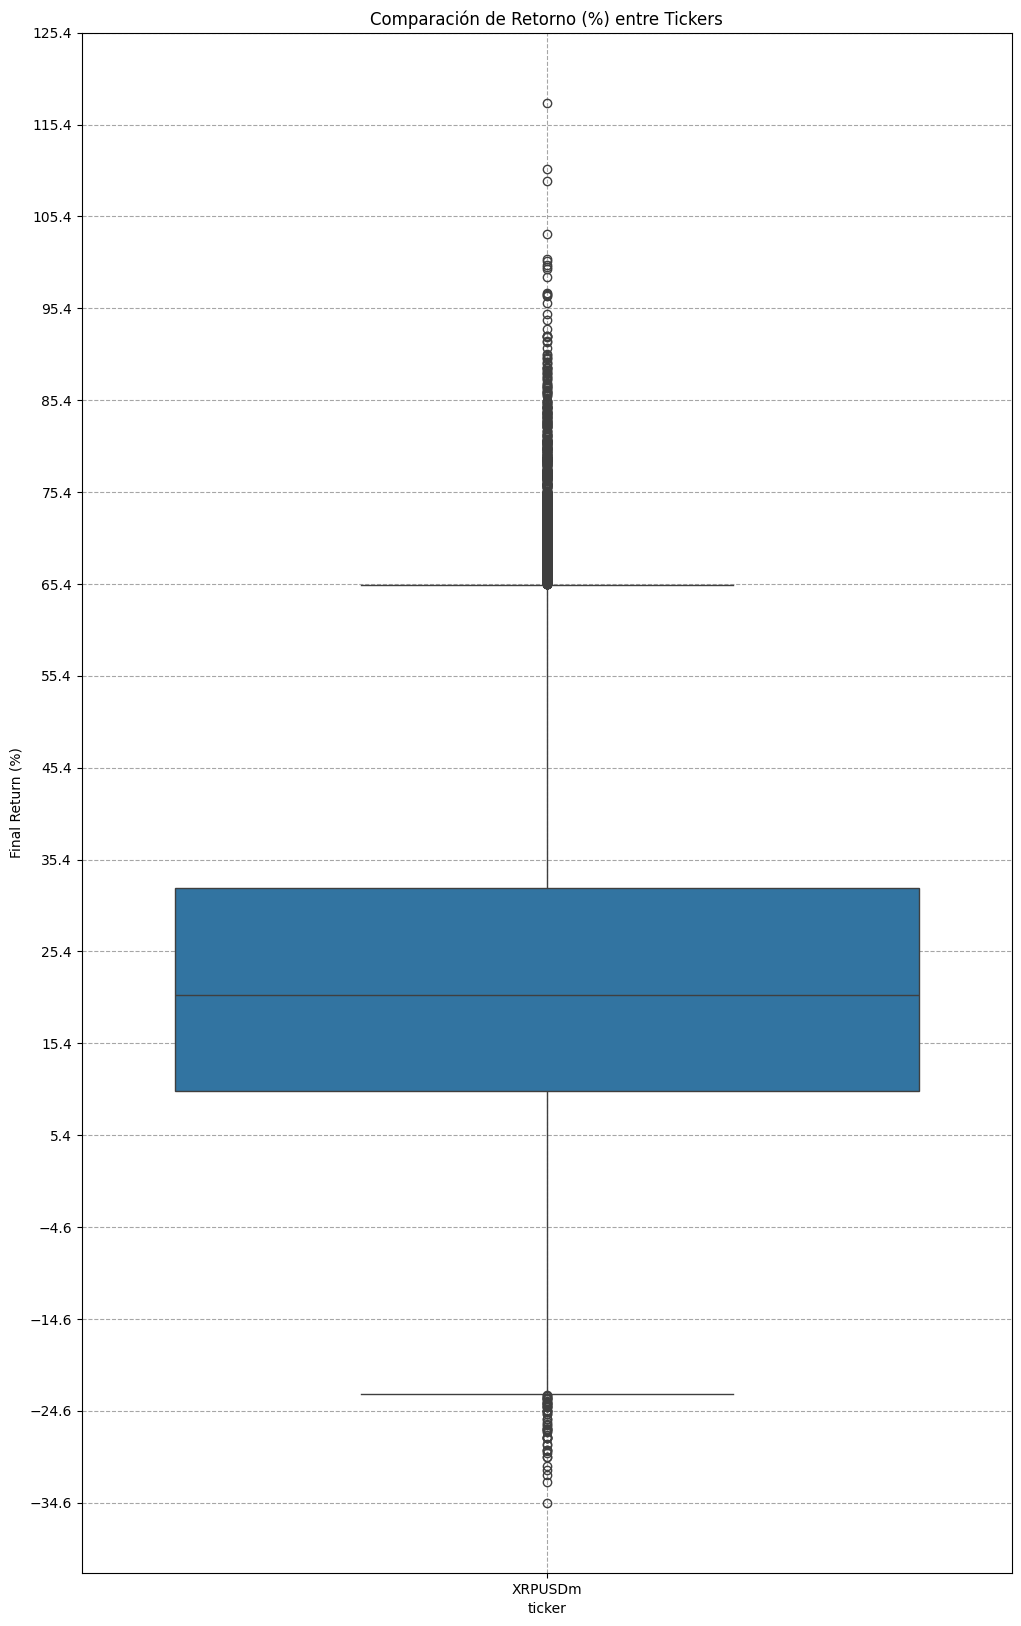

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Generar el gráfico
plt.figure(figsize=(12, 20))
sns.boxplot(data=all_returns, x="ticker", y="Final Return (%)")
plt.title("Comparación de Retorno (%) entre Tickers")

# Configurar ticks mayores con más números
y_max = all_returns["Final Return (%)"].max()  # Valor máximo en el eje Y
y_min = all_returns["Final Return (%)"].min()  # Valor mínimo en el eje Y
tick_interval = 10  # Intervalo deseado entre números en el eje Y

# Configurar los ticks mayores en el eje Y
plt.yticks(np.arange(y_min, y_max + tick_interval, tick_interval))

# Activar la cuadrícula
plt.grid(True, linestyle='--', which='both', color='grey', alpha=0.7)

# Mostrar el gráfico
plt.show()
